# Reporte de Análisis Exploratorio: Dataset CTG
**Alumno:** JOSUE JIMENEZ APODACA
**Fecha:** 22-11-2'25

## 1. Introducción
Este reporte utiliza la librería personalizada `ctg_viz` para analizar datos de cardiotocografía, limpiar el dataset y encontrar patrones visuales.

In [1]:
import pandas as pd
import sys
import os
import numpy as np
import inspect
from IPython.display import display, Markdown, HTML
import re

sys.path.append(os.path.abspath('..'))

from ctg_viz.preprocessing import remove_null_columns, impute_missing_values, detect_handle_outliers
from ctg_viz.utils import check_data_completeness_JosueJimenezApodaca
from ctg_viz.plots.histograms import plot_histogram_interactivo
from ctg_viz.plots.boxplots import plot_boxplot
from ctg_viz.plots.barplots import plot_bar
from ctg_viz.plots.heatmap import plot_correlation_heatmap
from ctg_viz.plots.density import plot_violin

df = pd.read_csv('../data/CTG.csv')
print("Datos cargados:", df.shape)

import plotly.io as pio
pio.renderers.default = "notebook_connected"

Datos cargados: (2129, 40)


In [2]:

def limpiar_firma(firma: str) -> str:
    """Limpia los tipos de datos largos para que sean legibles."""
    firma = firma.replace("pandas.core.frame.DataFrame", "pd.DataFrame")
    firma = firma.replace("pandas.core.series.Series", "pd.Series")
    firma = firma.replace("typing.", "")
    firma = firma.replace("NoneType", "None")
    firma = firma.replace("matplotlb.figure.Figure", "plt.Figure")
    return firma

def formatear_docstring(doc: str) -> str:
    """Da formato HTML básico al docstring (negritas en Args/Returns)."""
    if not doc:
        return "<span style='color: #999; font-style: italic;'>Sin documentación provista.</span>"
    
    # Escapar caracteres HTML para seguridad
    doc = doc.replace("<", "&lt;").replace(">", "&gt;")
    
    # Resaltar secciones clave (Args:, Returns:, Escenario:, etc.)
    keywords = ["Args:", "Returns:", "Raises:", "Escenario:", "Resultado Esperado:"]
    for kw in keywords:
        doc = doc.replace(kw, f"<br><b>{kw}</b>")
        
    # Convertir saltos de línea en <br> para HTML
    doc = doc.replace("\n", "<br>")
    return doc

def documentacion_estetica(modulo, titulo="Documentación Técnica"):
    """Genera tarjetas HTML elegantes para las funciones del módulo."""
    html_content = f"""
    <div style="font-family: 'Segoe UI', sans-serif; margin-bottom: 30px;">
        <h2 style="border-bottom: 2px solid #4CAF50; padding-bottom: 10px; color: #333;">
            📚 {titulo}: <span style="color: #4CAF50;">{modulo.__name__}</span>
        </h2>
    """
    
    funciones = inspect.getmembers(modulo, inspect.isfunction)
    
    for nombre, func in funciones:
        # Filtramos funciones privadas (que empiezan con _)
        if not nombre.startswith('_'):
            # 1. Obtener firma limpia
            try:
                firma = str(inspect.signature(func))
                firma = limpiar_firma(firma)
            except ValueError:
                firma = "()"
            
            # 2. Obtener y formatear docstring
            doc_raw = inspect.getdoc(func)
            doc_html = formatear_docstring(doc_raw)
            
            # 3. Crear la tarjeta HTML
            html_content += f"""
            <div style="border: 1px solid #e0e0e0; border-radius: 8px; margin-bottom: 20px; box-shadow: 0 2px 4px rgba(0,0,0,0.05); overflow: hidden;">
                <div style="background-color: #f8f9fa; padding: 10px 15px; border-bottom: 1px solid #e0e0e0;">
                    <code style="color: #0d47a1; font-weight: bold; font-size: 1.1em;">def {nombre}{firma}</code>
                </div>
                <div style="padding: 15px; background-color: white; color: #444; line-height: 1.6;">
                    {doc_html}
                </div>
            </div>
            """
            
    html_content += "</div>"
    display(HTML(html_content))

# Título del Reporte
display(Markdown("# Reporte Técnico y Análisis Exploratorio - CTG"))
display(Markdown("Este documento detalla la arquitectura de la librería `ctg_viz` y presenta el análisis de datos."))

# Reporte Técnico y Análisis Exploratorio - CTG

Este documento detalla la arquitectura de la librería `ctg_viz` y presenta el análisis de datos.

In [3]:
import ctg_viz.preprocessing as prep
import ctg_viz.utils as utils
import ctg_viz.plots as plots

display(Markdown("## 1. Arquitectura de la Librería Personalizada"))
documentacion_estetica(prep, titulo="Módulo de Preprocesamiento")
documentacion_estetica(utils, titulo="Módulo de Utilidades")
documentacion_estetica(plots.histograms, titulo="Módulo de Gráficas - Histogramas")
documentacion_estetica(plots.boxplots, titulo="Módulo de Gráficas - Boxplots")
documentacion_estetica(plots.barplots, titulo="Módulo de Gráficas - Barplots")
documentacion_estetica(plots.density, titulo="Módulo de Gráficas - Densidad")
documentacion_estetica(plots.heatmap,titulo="Módulo de Gráficas - Heatmap")

# Agregamos la carpeta ../tests
tests_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'tests'))
if tests_path not in sys.path:
    sys.path.append(tests_path)

try:
    import test_preprocessing
except ImportError:
    # Fallback por si el nombre o la ruta varía
    print("No se pudo importar el módulo de tests para leer docstrings.")
    test_preprocessing = None


# A) Mostrar la documentación de las funciones de test
if test_preprocessing:
    documentacion_estetica(test_preprocessing, titulo="Módulo de Tests - Funciones de preprocesamiento")


## 1. Arquitectura de la Librería Personalizada

## 2. Limpieza de Datos
Aplicamos reglas: eliminar columnas que presenten un porcentaje mayor al 20% de valores nulos e imputar valores faltantes (Numericos -> mediana y categoricos -> moda)

=== 1. ESTADO ORIGINAL DEL DATASET ===
Dimensiones Iniciales: 2129 filas x 40 columnas


,FileName,Date,SegFile,b,e,LBE,LB,AC,FM,UC,...,C,D,E,AD,DE,LD,FS,SUSP,CLASS,NSP
0,Variab10.txt,12/1/1996,CTG0001.txt,240.0,357.0,120.0,120.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0,2.0
1,Fmcs_1.txt,5/3/1996,CTG0002.txt,5.0,632.0,132.0,132.0,4.0,0.0,4.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
2,Fmcs_1.txt,5/3/1996,CTG0003.txt,177.0,779.0,133.0,133.0,2.0,0.0,5.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
3,Fmcs_1.txt,5/3/1996,CTG0004.txt,411.0,1192.0,134.0,134.0,2.0,0.0,6.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
4,Fmcs_1.txt,5/3/1996,CTG0005.txt,533.0,1147.0,132.0,132.0,4.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0



--- Reporte de Calidad (Antes de Limpieza) ---


,Nulos,% Completitud,Tipo Dato,Estadísticas,Categoría Auto
Columna,,,,,
FileName,3,99.86,object,N/A,Discreta
Date,3,99.86,object,N/A,Discreta
SegFile,3,99.86,object,N/A,Discreta
b,3,99.86,float64,"Min:0.00, Max:3296.00, Std:894.08",Continua
e,3,99.86,float64,"Min:287.00, Max:3599.00, Std:930.92",Continua
LBE,3,99.86,float64,"Min:106.00, Max:160.00, Std:9.84",Continua
LB,3,99.86,float64,"Min:106.00, Max:160.00, Std:9.84",Continua
AC,3,99.86,float64,"Min:0.00, Max:26.00, Std:3.56",Continua
FM,2,99.91,float64,"Min:0.00, Max:564.00, Std:39.03",Continua



--- Estadísticos Descriptivos (Originales) ---


,b,e,LBE,LB,AC,FM,UC,ASTV,MSTV,ALTV,...,C,D,E,AD,DE,LD,FS,SUSP,CLASS,NSP
count,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2127.000000,2127.000000,2127.000000,2127.000000,2127.000000,...,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000
mean,878.439793,1702.877234,133.303857,133.303857,2.722484,7.503056,3.669017,47.008933,1.335449,9.884814,...,0.024929,0.038100,0.033866,0.156162,0.118532,0.050329,0.032455,0.092662,4.509878,1.304327
std,894.084748,930.919143,9.840844,9.840844,3.560850,39.030452,2.877148,17.210648,0.891543,18.476534,...,0.155947,0.191482,0.180928,0.363094,0.323314,0.218675,0.177248,0.290027,3.026883,0.614377
min,0.000000,287.000000,106.000000,106.000000,0.000000,0.000000,0.000000,12.000000,0.200000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,55.000000,1009.000000,126.000000,126.000000,0.000000,0.000000,1.000000,32.000000,0.700000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000
50%,538.000000,1241.000000,133.000000,133.000000,1.000000,0.000000,3.000000,49.000000,1.200000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,1.000000
75%,1521.000000,2434.750000,140.000000,140.000000,4.000000,2.000000,5.000000,61.000000,1.700000,11.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,1.000000
max,3296.000000,3599.000000,160.000000,160.000000,26.000000,564.000000,23.000000,87.000000,7.000000,91.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10.000000,3.000000



=== APLICANDO PIPELINE DE LIMPIEZA ===
-> Columnas eliminadas por >20% nulos: Ninguna
-> Valores nulos imputados correctamente (KNN para numéricos, Moda para categóricos).
-> Outliers tratados con método IQR. Se generaron gráficos para 26 variables.


=== 3. ESTADO FINAL DEL DATASET ===
Dimensiones Finales: 2129 filas x 40 columnas

--- Clasificación Automática de Variables ---
📌 Variables Continuas (19):
['b', 'e', 'LBE', 'LB', 'AC', 'UC', 'ASTV', 'MSTV', 'ALTV', 'MLTV', 'Width', 'Min', 'Max', 'Nmax', 'Mode', 'Mean', 'Median', 'Variance', 'CLASS']

📌 Variables Discretas/Categóricas (21):
['FileName', 'Date', 'SegFile', 'FM', 'DL', 'DS', 'DP', 'DR', 'Nzeros', 'Tendency', 'A', 'B', 'C', 'D', 'E', 'AD', 'DE', 'LD', 'FS', 'SUSP', 'NSP']

--- Estadísticos Descriptivos (Variables Numéricas) ---


,count,mean,std,min,25%,50%,75%,max
b,2129.0,877.865308,893.687857,0.0,55.0,538.0,1518.0,3296.0
e,2129.0,1702.392051,930.397399,287.0,1009.0,1241.0,2434.0,3599.0
LBE,2129.0,133.299156,9.835560,106.0,126.0,133.0,140.0,160.0
LB,2129.0,133.299156,9.835560,106.0,126.0,133.0,140.0,160.0
AC,2129.0,2.578451,3.122799,0.0,0.0,1.0,4.0,10.0
FM,2129.0,1.250728,1.897491,0.0,0.0,0.0,2.0,5.0
UC,2129.0,3.636575,2.755725,0.0,1.0,3.0,5.0,11.0
ASTV,2129.0,47.015504,17.205231,12.0,32.0,49.0,61.0,87.0
MSTV,2129.0,1.300590,0.771567,0.2,0.7,1.2,1.7,3.2
ALTV,2129.0,6.662698,10.290142,0.0,0.0,0.0,11.0,27.5



--- Resumen de Variables Categóricas (Top 5) ---


,count,unique,top,freq
FileName,2129,352,S8001034.dsp,37
Date,2129,48,2/22/1995,243
SegFile,2129,2126,CTG0001.txt,4


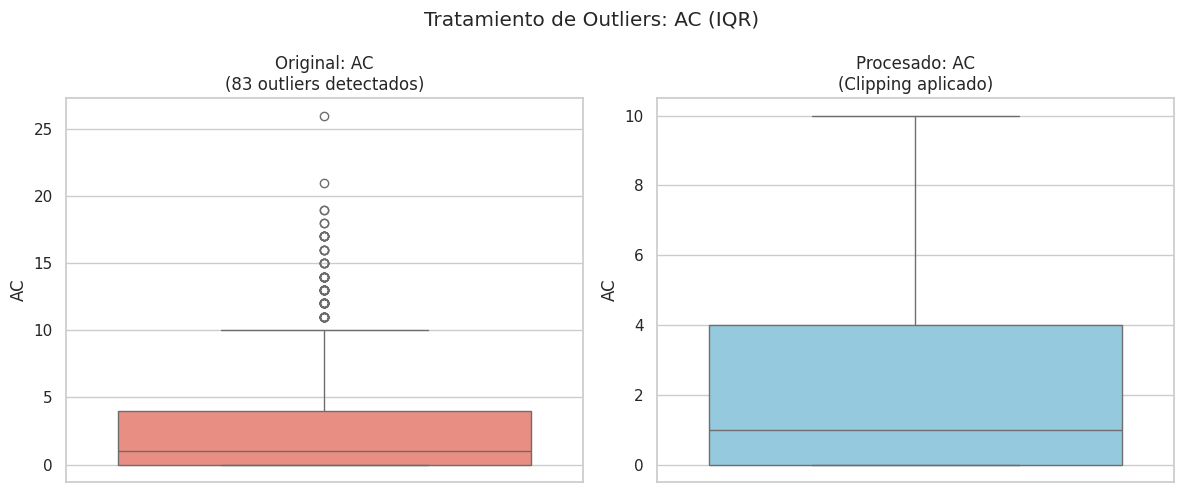

In [4]:
# --- BLOQUE 1: ANÁLISIS DEL ESTADO INICIAL (RAW) ---
print("=== 1. ESTADO ORIGINAL DEL DATASET ===")
print(f"Dimensiones Iniciales: {df.shape[0]} filas x {df.shape[1]} columnas")

display(df.head())

# Usamos tu función personalizada para ver Tipos y Nulos antes de limpiar
print("\n--- Reporte de Calidad (Antes de Limpieza) ---")
reporte_inicial = check_data_completeness_JosueJimenezApodaca(df)
display(reporte_inicial)

print("\n--- Estadísticos Descriptivos (Originales) ---")
display(df.describe())

# --- BLOQUE 2: PROCESAMIENTO (LIMPIEZA) ---
print("\n" + "="*40)
print("=== APLICANDO PIPELINE DE LIMPIEZA ===")
print("="*40)

# 1. Eliminar columnas con exceso de nulos (>20%) 
df_clean_step1 = remove_null_columns(df, threshold=0.2)
cols_eliminadas = set(df.columns) - set(df_clean_step1.columns)
print(f"-> Columnas eliminadas por >20% nulos: {cols_eliminadas if cols_eliminadas else 'Ninguna'}")

# 2. Imputación (KNN o Moda/Mediana)
# En caso de variables numéricas, usamos KNN; para categóricas, usamos la moda.
# Si no quieres usar KNN, cambia use_knn a False
df_clean_step2 = impute_missing_values(df_clean_step1, use_knn=True)
print("-> Valores nulos imputados correctamente (KNN para numéricos, Moda para categóricos).")

# 3. Tratamiento de Outliers
df_final, figs_outliers = detect_handle_outliers(df_clean_step2, method='iqr', return_plots=True)
print(f"-> Outliers tratados con método IQR. Se generaron gráficos para {len(figs_outliers)} variables.")


# --- BLOQUE 3: ANÁLISIS FINAL (PROCESADO) ---
print("\n\n=== 3. ESTADO FINAL DEL DATASET ===")
print(f"Dimensiones Finales: {df_final.shape[0]} filas x {df_final.shape[1]} columnas")

# Reporte de calidad FINAL
reporte_final = check_data_completeness_JosueJimenezApodaca(df_final)

# --- VISUALIZACIÓN DE CLASIFICACIÓN DE VARIABLES ---
print("\n--- Clasificación Automática de Variables ---")
# Filtramos el reporte para separar las listas
vars_continuas = reporte_final[reporte_final['Categoría Auto'] == 'Continua'].index.tolist()
vars_discretas = reporte_final[reporte_final['Categoría Auto'] == 'Discreta'].index.tolist()

print(f"📌 Variables Continuas ({len(vars_continuas)}):")
print(vars_continuas)
print(f"\n📌 Variables Discretas/Categóricas ({len(vars_discretas)}):")
print(vars_discretas)

# --- ESTADÍSTICOS DESCRIPTIVOS (SOLO NUMÉRICOS) ---
print("\n--- Estadísticos Descriptivos (Variables Numéricas) ---")
# Filtramos solo columnas numéricas para el describe
stats_finales = df_final.select_dtypes(include=[np.number]).describe().T
display(stats_finales)

if len(vars_discretas) > 0:
    print("\n--- Resumen de Variables Categóricas (Top 5) ---")
    cat_cols = df_final.select_dtypes(exclude=[np.number]).columns
    if len(cat_cols) > 0:
        display(df_final[cat_cols].describe().T)


if len(figs_outliers) > 0:
    col_ejemplo = list(figs_outliers.keys())[0]
    display(figs_outliers[col_ejemplo])

## 3. Análisis
Una vez que se ejecutó el preprocesamiento, realiazamos análisis sobre los resultados

### 3.1 Distribución de Variables (Histogramas)
Observamos la distribución de la frecuencia cardiaca fetal (LB).

In [5]:
# Visualizar distribución de Línea Base (LB) agrupada por Clase (NSP)
fig_hist = plot_histogram_interactivo(
    df_final, 
    col='LB',       # Variable numérica
    group_by='NSP'  # Variable categórica (colores)
)
fig_hist.show()

### 3.2 Comparación por Clases (Boxplots)
Analizamos la variabilidad según el estado fetal (NSP).

In [6]:
# Comparar Variabilidad a Corto Plazo (ASTV) según la clase (NSP)
fig_box = plot_boxplot(
    df_final, 
    x='NSP',      # Eje X (Categoría)
    y='ASTV',     # Eje Y (Numérica)
    facet_col='NSP' # Separa en columnas distintas (Faceting)
)
fig_box.show()

### 3.3 Correlaciones (Heatmap)
Buscamos variables redundantes.

In [7]:
# Matriz de correlación de variables numéricas
fig_corr = plot_correlation_heatmap(
    df_final, 
    method='spearman' 
)
fig_corr.show()

### 3.4 Gráfico de Barras (Frecuencias)
Para ver el desbalance de clases (cuántos sanos vs. patológicos hay).

In [8]:
# Conteo de casos por Categoría de Estado Fetal (NSP)
fig_bar = plot_bar(
    df_final, 
    col='NSP', 
    horizontal=True
)
fig_bar.show()

### 3.5 Violin Plot (Densidad + Puntos)
Muestra la "forma" de los datos.

In [9]:
# Densidad de Aceleraciones (AC) por Clase
fig_violin = plot_violin(
    df_final, 
    x='NSP', 
    y='AC'
)
fig_violin.show()

## 4. Conclusiones y Recomendaciones
1. **Calidad de Datos:** Se eliminaron X columnas por falta de datos. La imputación KNN preservó la varianza en las variables clave.
2. **Patrones:** La variable `ASTV` muestra una fuerte correlación con el estado patológico (NSP=3), lo que sugiere que es un predictor clave.
3. **Outliers:** Se detectaron y toparon valores extremos en `LB`, mejorando la estabilidad de la distribución.

## 5. Validacion de funciones

En esta seccion se testean las funcionalidades de las funciones usadas en el proyecto

In [10]:
### Ejecutar las pruebas (El "Resultado")
print("\n" + "="*40)
print("▶️ EJECUCIÓN DE PYTEST (EVIDENCIA)")
print("="*40)

%cd ..
!pytest tests/ -v
%cd notebooks


▶️ EJECUCIÓN DE PYTEST (EVIDENCIA)
/home/josuej/Documentos/Practica3/ctg_viz
]9;4;3;\============================= test session starts ==============================
platform linux -- Python 3.11.11, pytest-9.0.1, pluggy-1.6.0 -- /home/josuej/.pyenv/versions/3.11.11/bin/python3.11
cachedir: .pytest_cache
rootdir: /home/josuej/Documentos/Practica3/ctg_viz
collected 4 items                                                              

tests/test_preprocessing.py::test_remove_null_columns ]9;4;1;0\PASSED             [ 25%]
tests/test_preprocessing.py::test_impute_missing_values_mode ]9;4;1;25\PASSED      [ 50%]
tests/test_preprocessing.py::test_detect_handle_outliers_iqr ]9;4;1;50\PASSED      [ 75%]
tests/test_preprocessing.py::test_check_data_completeness_structure ]9;4;1;75\PASSED [100%]]9;4;0;\

============================== 4 passed in 0.90s ===============================
/home/josuej/Documentos/Practica3/ctg_viz/notebooks
